In [1]:
import numpy as np
import matplotlib.pyplot as plt
from regions import Regions
import regions
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u

from dust_extinction.averages import CT06_MWGC

from smart_plotters.jwst_plots import JWSTCatalog, make_cat_use, make_brick_cat
from smart_plotters.cutout_plot import get_cutout_405, get_cutout_jwst_ice
import smart_plotters.co_ice as co_map
from smart_plotters import cmd_plot

#import importlib as imp

#imp.reload(cmd_plot)

In [2]:
cat_use = make_cat_use()


In [3]:
cat_use.catalog['Av'] = cat_use.get_Av('f182m', 'f212n')
cat_use.catalog['N(CO)'] = co_map.get_co_ice_column(cat_use, cat_use.catalog['Av'], ext=CT06_MWGC(), ref_band='f405n')

In [4]:
cat_brick = make_brick_cat()

Reading /orange/adamginsburg/jwst/brick/catalogs/basic_merged_indivexp_photometry_tables_merged_qualcuts_oksep2221.fits


In [5]:
cat_brick.catalog['Av'] = cat_brick.get_Av('f182m', 'f212n')
cat_brick.catalog['N(CO)'] = co_map.get_co_ice_column(cat_brick, cat_brick.catalog['Av'], ext=CT06_MWGC(), ref_band='f405n')

In [6]:
# Deredden F212N and F466N 
def unextinct(cat, ext, band1, band2, Av):
    EV_band2_band1 = (ext(int(band2[1:-1])/100*u.um) - ext(int(band1[1:-1])/100*u.um))
    return cat.color(band1, band2) + EV_band2_band1 * Av

from dust_extinction.averages import CT06_MWGC, CT06_MWLoc

# Color = F212N - F466N
cat_use.catalog['Av'] = cat_use.get_Av('f182m', 'f212n')
unextinct_212_466 = unextinct(cat_use, CT06_MWGC(), 'f212n', 'f466n', Av=cat_use.catalog['Av'])
unextinct_405_466 = unextinct(cat_use, CT06_MWGC(), 'f405n', 'f466n', Av=cat_use.catalog['Av'])

cat_use.catalog['unextinct_212_466'] = unextinct_212_466
cat_use.catalog['unextinct_405_466'] = unextinct_405_466

In [7]:
cat_brick.catalog['Av'] = cat_brick.get_Av('f182m', 'f212n')
unextinct_212_466_brick = unextinct(cat_brick, CT06_MWGC(), 'f212n', 'f466n', Av=cat_brick.catalog['Av'])
unextinct_405_466_brick = unextinct(cat_brick, CT06_MWGC(), 'f405n', 'f466n', Av=cat_brick.catalog['Av'])

cat_brick.catalog['unextinct_212_466'] = unextinct_212_466_brick
cat_brick.catalog['unextinct_405_466'] = unextinct_405_466_brick

In [8]:
fn = '/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits'
hdu = fits.open(fn)
ww = WCS(hdu['SCI'].header)
nanfield = np.nan * hdu['SCI'].data

In [9]:
fn_brick = '/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-merged_i2d.fits'
hdu_brick = fits.open(fn_brick)
ww_brick = WCS(hdu_brick['SCI'].header)
nanfield_brick = np.nan * hdu_brick['SCI'].data

# RC Selection

In [10]:
def get_rc_sel_mask(cat):
    x = np.linspace(0, 2.5, 10)
    
    x0 = 0.52
    mask_x0_left = cat.color('f182m', 'f212n') > x0

    y0 = 14.8
    mask_above_y0 = cat.band('f182m') > y0
    mask_rc = mask_above_y0 & mask_x0_left

    pt1 = (0.5, 14.3)
    pt2 = (2.0, 20.)
    y1 = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (x - pt1[0]) + pt1[1]
    mask_below_y1 = cat.band('f182m') > ( (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (cat.color('f182m', 'f212n') - pt1[0]) + pt1[1] )
    mask_rc = mask_below_y1 & mask_rc

    pt1 = (0.5, 15.5)
    pt2 = (2.0, 20.9)
    y2 = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (x - pt1[0]) + pt1[1]
    mask_above_y2 = cat.band('f182m') < ( (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (cat.color('f182m', 'f212n') - pt1[0]) + pt1[1] )
    mask_rc = mask_rc & mask_above_y2

    return mask_rc

In [11]:
cat_inbox_brick = JWSTCatalog(cat_brick.catalog[get_rc_sel_mask(cat_brick)])
cat_inbox = JWSTCatalog(cat_use.catalog[get_rc_sel_mask(cat_use)])

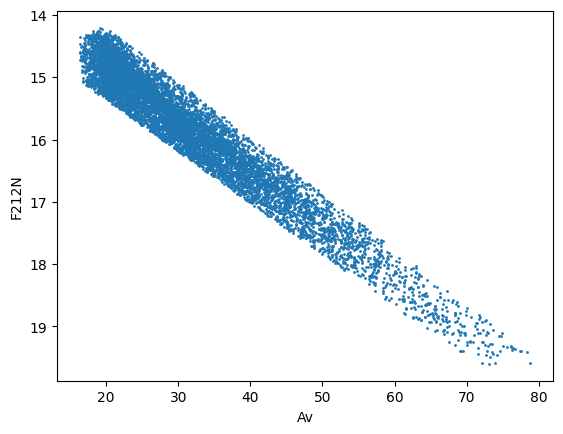

In [12]:
plt.scatter(cat_inbox.catalog['Av'], cat_inbox.band('f212n'), s=1)
plt.xlabel('Av')
plt.ylabel('F212N')
plt.gca().invert_yaxis()

(0.0, 3.0)

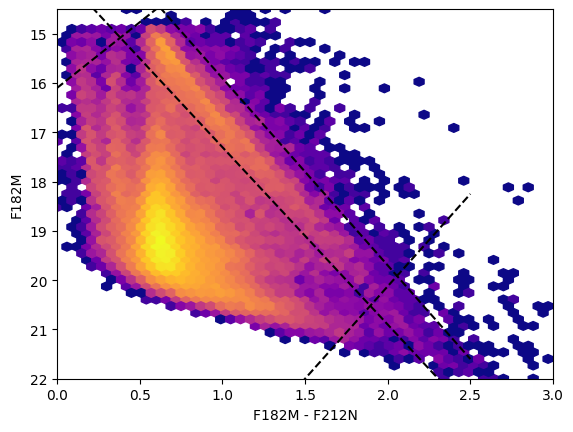

In [13]:
plt.hexbin(cat_use.color('f182m', 'f212n'), cat_use.band('f182m'), extent=(0, 3, 14.5, 22), mincnt=1, gridsize=50, cmap='plasma', bins='log')
x = np.linspace(0, 2.5, 10)
pt1 = (0.5, 14)
pt2 = (2.0, 19.7)
y = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (x - pt1[0]) + pt1[1]
plt.plot(x, y, color='k', linestyle='dashed')

pt1 = (0.5, 15.5)
pt2 = (2.0, 20.9)
y = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (x - pt1[0]) + pt1[1]
plt.plot(x, y, color='k', linestyle='dashed')

pt1 = (0.3, 15.3)
pt2 = (0.6, 14.5)
y = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (x - pt1[0]) + pt1[1]
plt.plot(x, y, color='k', linestyle='dashed')

pt1 = (1.9, 20.5)
pt2 = (1.5, 22)
y = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (x - pt1[0]) + pt1[1]
plt.plot(x, y, color='k', linestyle='dashed')

plt.gca().invert_yaxis()
plt.xlabel('F182M - F212N')
plt.ylabel('F182M')
plt.ylim(22, 14.5)
plt.xlim(0, 3)

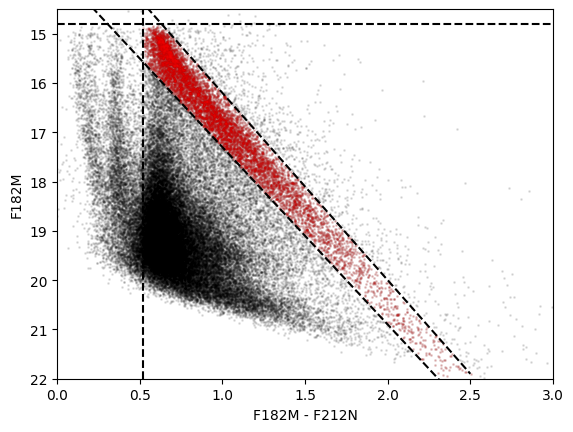

In [14]:
#plt.hexbin(cat_use.color('f182m', 'f212n'), cat_use.band('f182m'), extent=(0, 3, 14.5, 22), mincnt=1, gridsize=50, cmap='plasma', bins='log')

cat_use.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.1, color='k')

x = np.linspace(0, 2.5, 10)

x0 = 0.52
mask_x0_left = cat_use.color('f182m', 'f212n') > x0
plt.axvline(x0, color='k', linestyle='dashed')

y0 = 14.8
mask_above_y0 = cat_use.band('f182m') > y0
mask_inbox = mask_above_y0 & mask_x0_left
plt.axhline(y0, color='k', linestyle='dashed')

pt1 = (0.5, 14.3)
pt2 = (2.0, 20.)
y1 = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (x - pt1[0]) + pt1[1]
mask_below_y1 = cat_use.band('f182m') > ( (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (cat_use.color('f182m', 'f212n') - pt1[0]) + pt1[1] )
mask_inbox = mask_below_y1 & mask_inbox
plt.plot(x, y1, color='k', linestyle='dashed')

pt1 = (0.5, 15.5)
pt2 = (2.0, 20.9)
y2 = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (x - pt1[0]) + pt1[1]
mask_above_y2 = cat_use.band('f182m') < ( (pt2[1] - pt1[1]) / (pt2[0] - pt1[0]) * (cat_use.color('f182m', 'f212n') - pt1[0]) + pt1[1] )
mask_inbox = mask_inbox & mask_above_y2
plt.plot(x, y2, color='k', linestyle='dashed')

cat_inbox = JWSTCatalog(cat_use.catalog[mask_inbox])
cat_inbox.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.1, color='r')

plt.gca().invert_yaxis()
plt.xlabel('F182M - F212N')
plt.ylabel('F182M')
plt.ylim(22, 14.5)
plt.xlim(0, 3)
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/rc_selection_cmd.png', dpi=300)

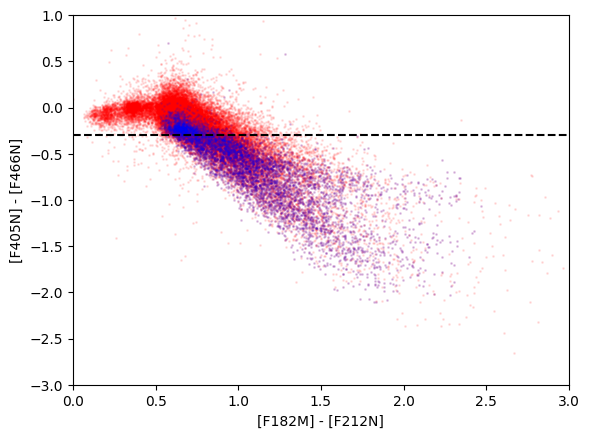

In [15]:
cat_use.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.1, color='r')
cat_inbox.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.1, color='blue')
plt.xlim(0, 3)
plt.ylim(-3, 1)
plt.axhline(-0.3, color='k', linestyle='dashed')

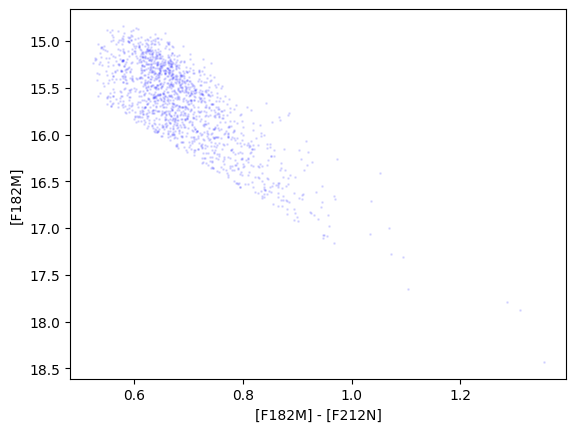

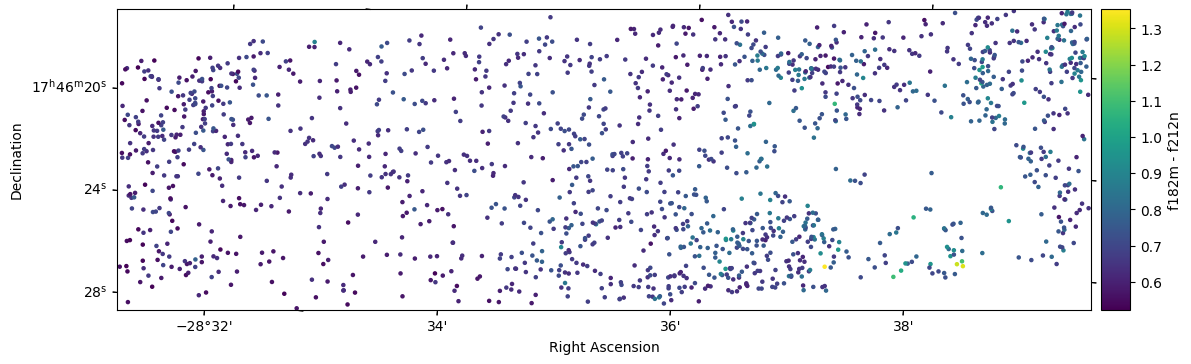

In [16]:
cat_inbox_blue = JWSTCatalog(cat_inbox.catalog[cat_inbox.color('f405n', 'f466n') > -0.3])

ax = plt.subplot(111)
cat_inbox_blue.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.1, color='blue')
plt.show()

fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111, projection=ww)
ax.imshow(nanfield)
cat_inbox_blue.plot_position(s=5, c=cat_inbox_blue.color('f182m', 'f212n'), cmap='viridis', transform=ax.get_transform('world'))
cax = ax.inset_axes([1.01, 0., 0.03, 1])
plt.colorbar(ax.collections[0], cax=cax, orientation='vertical', label='f182m - f212n')

plt.tight_layout()

(-0.3, 0.0)

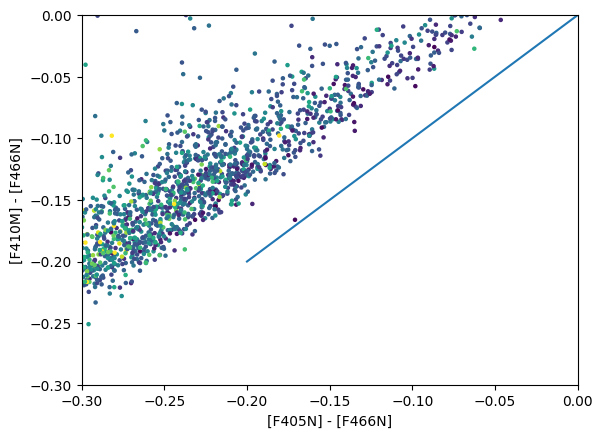

In [17]:
cat_inbox_blue.plot_CCD('f405n', 'f466n', 'f410m', 'f466n', s=5, alpha=1, c=cat_inbox_blue.color('f182m', 'f212n'), vmax=1)
plt.plot([-0.2, 0.6], [-0.2, 0.6])
plt.xlim(-0.3, 0)
plt.ylim(-0.3, 0)

(0.0, 3.1)

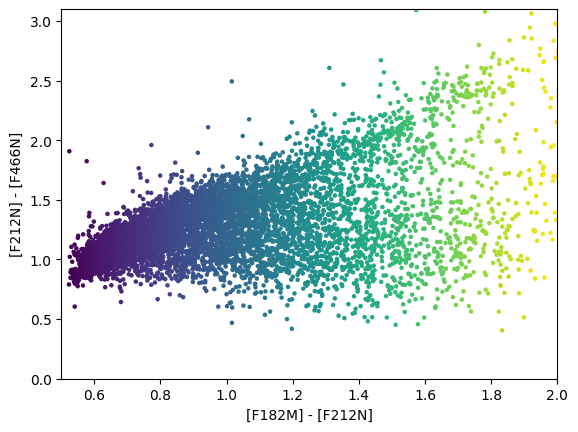

In [18]:
cat_inbox.plot_CCD('f182m', 'f212n', 'f212n', 'f466n', s=5, alpha=1, c=cat_inbox.color('f182m', 'f212n'), vmax=2)
plt.xlim(0.5, 2)
plt.ylim(0, 3.1)

In [19]:
cat_inbox.catalog['Av'] = cat_inbox.get_Av('f182m', 'f212n')

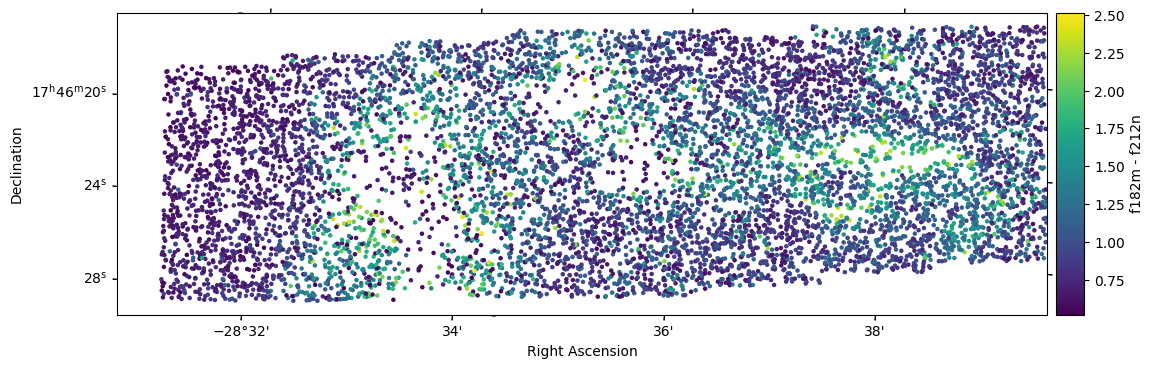

In [20]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(projection=ww)
ax.imshow(nanfield)
cat_inbox.plot_position(s=5, c=cat_inbox.color('f182m', 'f212n'), cmap='viridis', transform=ax.get_transform('world'))
cax = ax.inset_axes([1.01, 0., 0.03, 1])
plt.colorbar(ax.collections[0], cax=cax, orientation='vertical', label='f182m - f212n')
#cax = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical', label='f182m - f212n')


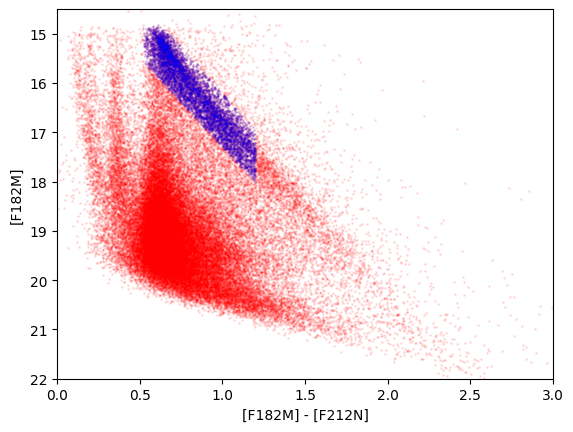

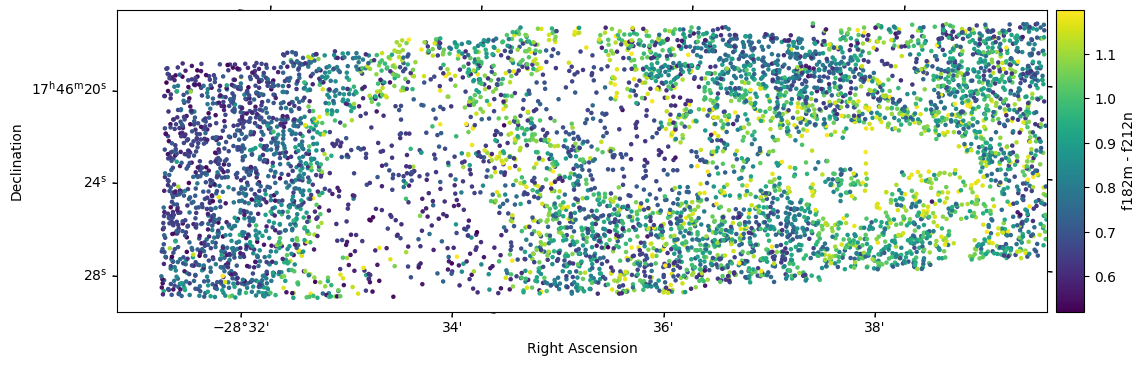

In [21]:
mask_blue = cat_inbox.color('f182m', 'f212n') < 1.2
cat_inbox_blue = JWSTCatalog(cat_inbox.catalog[mask_blue])

cat_use.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.1, color='r')
cat_inbox_blue.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.1, color='blue')
plt.gca().invert_yaxis()
plt.ylim(22, 14.5)
plt.xlim(0, 3)
plt.show()

fig = plt.figure(figsize=(12,8))
ax = plt.subplot(projection=ww)
ax.imshow(nanfield)
cat_inbox_blue.plot_position(s=5, c=cat_inbox_blue.color('f182m', 'f212n'), cmap='viridis', transform=ax.get_transform('world'))
cax = ax.inset_axes([1.01, 0., 0.03, 1])
plt.colorbar(ax.collections[0], cax=cax, orientation='vertical', label='f182m - f212n')
#cax = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical', label='f182m - f212n')


## Refining Selection to the most sure stars

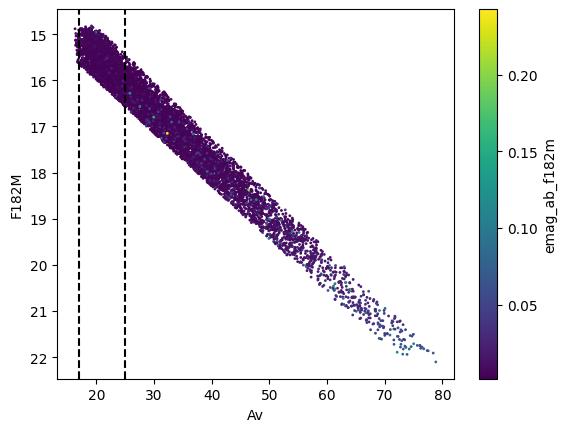

In [22]:
#cat_inbox.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.1, cmap='viridis', c=cat_inbox.catalog['Av'])

im = plt.scatter(cat_inbox.catalog['Av'], cat_inbox.band('f182m'), s=1, c=cat_inbox.catalog['emag_ab_f182m'], cmap='viridis')
plt.xlabel('Av')
plt.ylabel('F182M')
plt.gca().invert_yaxis()
plt.colorbar(im, label='emag_ab_f182m')
plt.axvline(17, color='k', linestyle='dashed')
plt.axvline(25, color='k', linestyle='dashed')
plt.show()

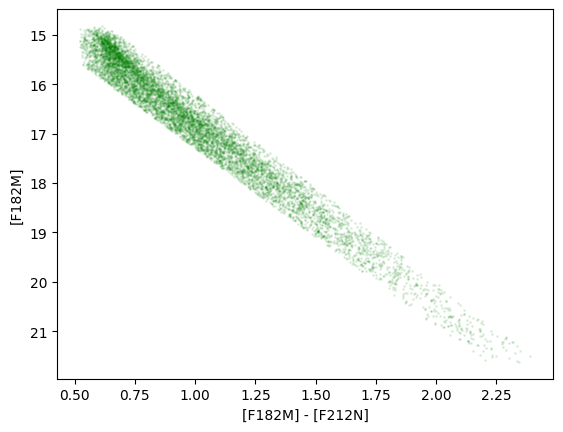

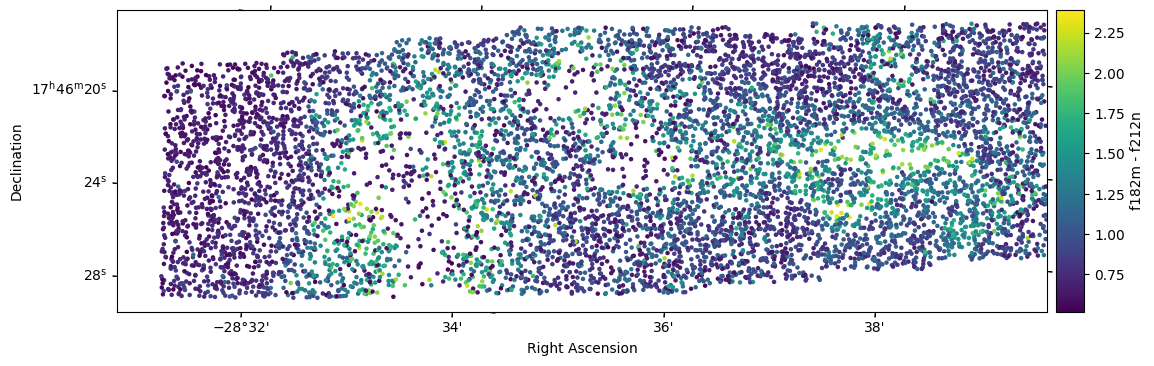

In [23]:
cat_inbox_lowE = JWSTCatalog(cat_inbox.catalog[cat_inbox.catalog['emag_ab_f182m'] < 0.05])
cat_inbox_lowE.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.1, color='green')
plt.show()

fig = plt.figure(figsize=(12,8))
ax = plt.subplot(projection=ww)
ax.imshow(nanfield)
cat_inbox_lowE.plot_position(s=5, c=cat_inbox_lowE.color('f182m', 'f212n'), cmap='viridis', transform=ax.get_transform('world'))
cax = ax.inset_axes([1.01, 0., 0.03, 1])
plt.colorbar(ax.collections[0], cax=cax, orientation='vertical', label='f182m - f212n')

# Region Selection

In [24]:
reg_f = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/filament_short.region')
reg_c1 = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/cloudc1.region')
reg_c2 = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/cloudc2.region')
reg_d = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/cloudd.region')
reg_b = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/cloudb.region')
reg_brick = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/brick.region')

reg_c1_ice = Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/cloudc1_ice.reg')
reg_c2_ice = Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/cloudc2_ice.reg')
reg_d_ice = Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/cloudd_ice.reg')

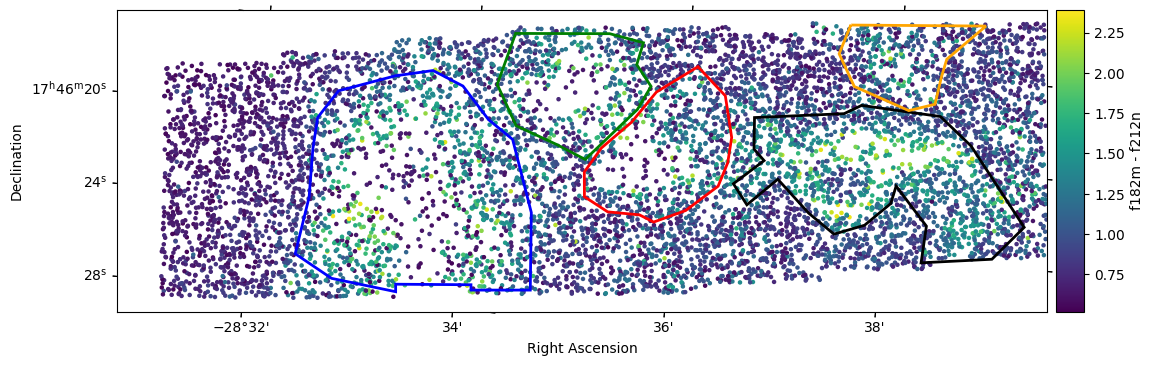

In [25]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(projection=ww)
ax.imshow(nanfield)
cat_inbox_lowE.plot_position(s=5, c=cat_inbox_lowE.color('f182m', 'f212n'), cmap='viridis', transform=ax.get_transform('world'))
cax = ax.inset_axes([1.01, 0., 0.03, 1])
plt.colorbar(ax.collections[0], cax=cax, orientation='vertical', label='f182m - f212n')

reg_f[0].to_pixel(ww).plot(ax=ax, edgecolor='k', facecolor='none', lw=2)
reg_c1_ice[0].to_pixel(ww).plot(ax=ax, edgecolor='r', facecolor='none', lw=2)
reg_c2_ice[0].to_pixel(ww).plot(ax=ax, edgecolor='g', facecolor='none', lw=2)
reg_d_ice[0].to_pixel(ww).plot(ax=ax, edgecolor='b', facecolor='none', lw=2)
reg_b[0].to_pixel(ww).plot(ax=ax, edgecolor='orange', facecolor='none', lw=2)

plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/cloudc_regions.png', dpi=300)

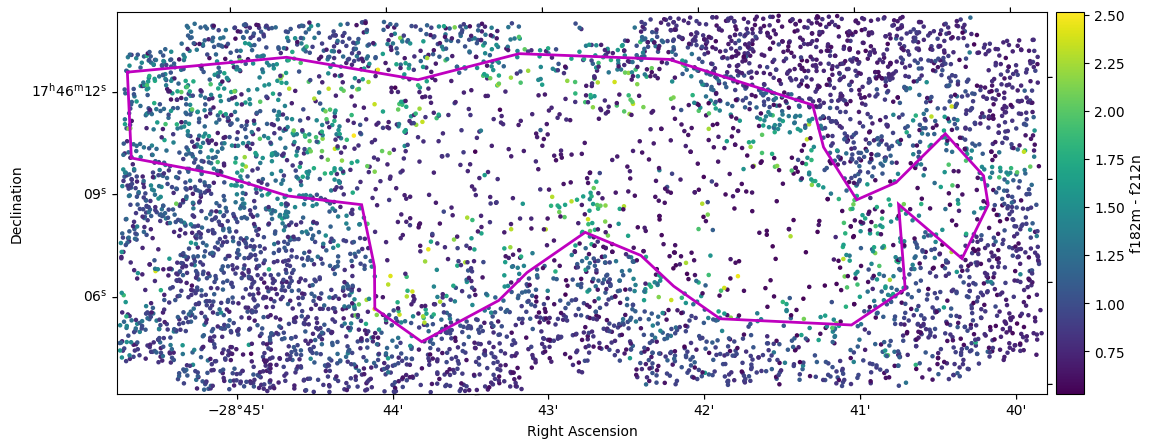

In [26]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(projection=ww_brick)
ax.imshow(nanfield_brick)
cat_inbox_brick.plot_position(s=5, c=cat_inbox_brick.color('f182m', 'f212n'), cmap='viridis', transform=ax.get_transform('world'))
cax = ax.inset_axes([1.01, 0., 0.03, 1])
plt.colorbar(ax.collections[0], cax=cax, orientation='vertical', label='f182m - f212n')

reg_brick[0].to_pixel(ww_brick).plot(ax=ax, edgecolor='m', facecolor='none', lw=2)

In [27]:
cat_inbox_f = JWSTCatalog(cat_inbox_lowE.table_region_mask(reg_f, ww))
cat_inbox_c1 = JWSTCatalog(cat_inbox_lowE.table_region_mask(reg_c1_ice, ww))
cat_inbox_c2 = JWSTCatalog(cat_inbox_lowE.table_region_mask(reg_c2_ice, ww))
cat_inbox_d = JWSTCatalog(cat_inbox_lowE.table_region_mask(reg_d_ice, ww))
cat_inbox_b = JWSTCatalog(cat_inbox_lowE.table_region_mask(reg_b, ww))
cat_inbox_brick_reg = JWSTCatalog(cat_inbox_brick.table_region_mask(reg_brick, ww_brick))

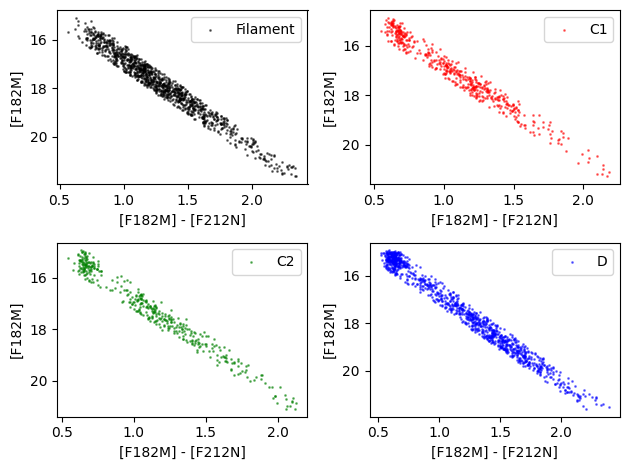

In [28]:
plt.subplot(221)
cat_inbox_f.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.5, color='k', label='Filament')
plt.legend()

plt.subplot(222)
cat_inbox_c1.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.5, color='r', label='C1')
plt.legend()

plt.subplot(223)
cat_inbox_c2.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.5, color='g', label='C2')
plt.legend()

plt.subplot(224)
cat_inbox_d.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.5, color='b', label='D')
plt.legend()

plt.tight_layout()

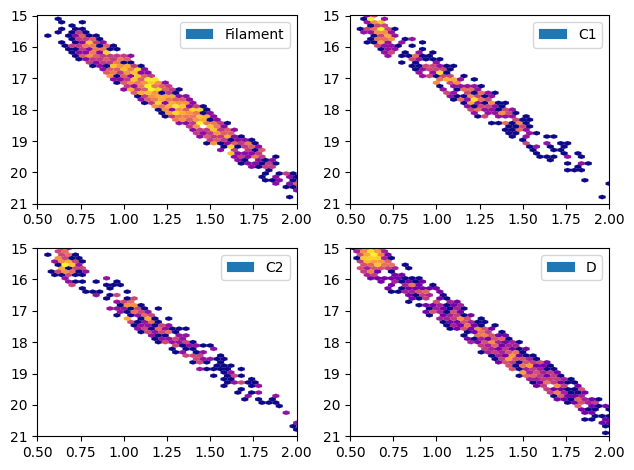

In [29]:
plt.subplot(221)
#cat_inbox_f.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.5, color='k', label='Filament')
plt.hexbin(cat_inbox_f.color('f182m', 'f212n'), cat_inbox_f.band('f182m'), extent=(0, 2, 15, 21), mincnt=1, gridsize=50, cmap='plasma', bins='log', label='Filament', linewidths=0.1)
plt.gca().invert_yaxis()
plt.xlim(0.5, 2)
plt.ylim(21, 15)
plt.legend()

plt.subplot(222)
#cat_inbox_c1.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.5, color='r', label='C1')
plt.hexbin(cat_inbox_c1.color('f182m', 'f212n'), cat_inbox_c1.band('f182m'), extent=(0, 2, 15, 21), mincnt=1, gridsize=50, cmap='plasma', bins='log', label='C1', linewidths=0.1)
plt.gca().invert_yaxis()
plt.xlim(0.5, 2)
plt.ylim(21, 15)
plt.legend()

plt.subplot(223)
#cat_inbox_c2.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.5, color='g', label='C2')
plt.hexbin(cat_inbox_c2.color('f182m', 'f212n'), cat_inbox_c2.band('f182m'), extent=(0, 2, 15, 21), mincnt=1, gridsize=50, cmap='plasma', bins='log', label='C2', linewidths=0.1)
plt.gca().invert_yaxis()
plt.xlim(0.5, 2)
plt.ylim(21, 15)
plt.legend()

plt.subplot(224)
#cat_inbox_d.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.5, color='b', label='D')
plt.hexbin(cat_inbox_d.color('f182m', 'f212n'), cat_inbox_d.band('f182m'), extent=(0, 2, 15, 21), mincnt=1, gridsize=50, cmap='plasma', bins='log', label='D', linewidths=0.1)
plt.gca().invert_yaxis()
plt.xlim(0.5, 2)
plt.ylim(21, 15)
plt.legend()

plt.tight_layout()

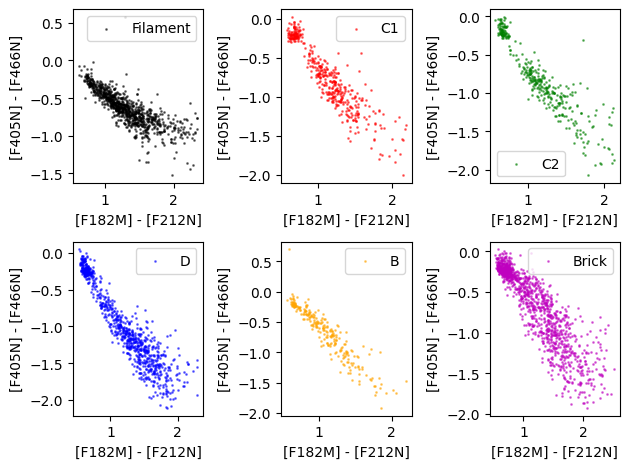

In [30]:
plt.subplot(231)
cat_inbox_f.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='k', label='Filament')
plt.legend()

plt.subplot(232)
cat_inbox_c1.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='r', label='C1')
plt.legend()

plt.subplot(233)
cat_inbox_c2.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='g', label='C2')
plt.legend()

plt.subplot(234)
cat_inbox_d.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='b', label='D')
plt.legend()

plt.subplot(235)
cat_inbox_b.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='orange', label='B')
plt.legend()

plt.subplot(236)
cat_inbox_brick_reg.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='m', label='Brick')
plt.legend()

plt.tight_layout()


## Restricted Regions

In [31]:
reg_c1_restricted = Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/cloudc1_restricted.reg')
reg_c2_restricted = Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/cloudc2_restricted.reg')
reg_d_restricted = Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/cloudd_restricted.reg')


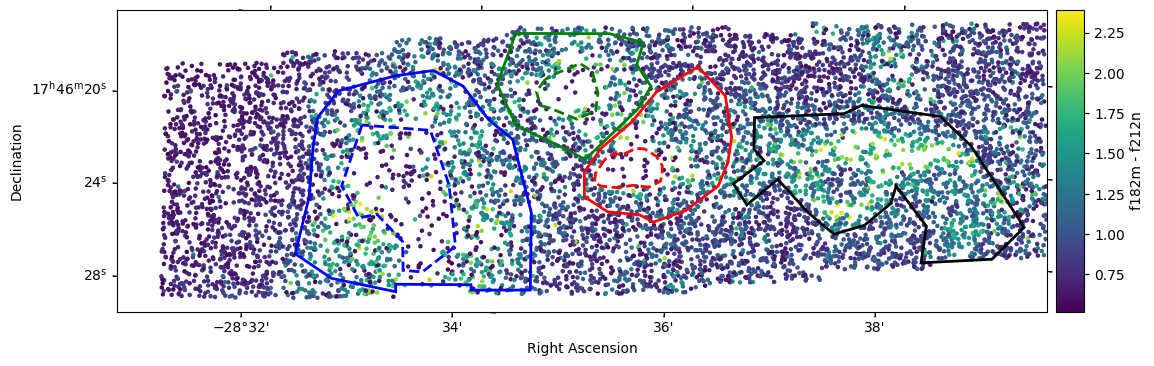

In [32]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(projection=ww)
ax.imshow(nanfield)
cat_inbox_lowE.plot_position(s=5, c=cat_inbox_lowE.color('f182m', 'f212n'), cmap='viridis', transform=ax.get_transform('world'))
cax = ax.inset_axes([1.01, 0., 0.03, 1])
plt.colorbar(ax.collections[0], cax=cax, orientation='vertical', label='f182m - f212n')

reg_f[0].to_pixel(ww).plot(ax=ax, edgecolor='k', facecolor='none', lw=2)
reg_c1_ice[0].to_pixel(ww).plot(ax=ax, edgecolor='r', facecolor='none', lw=2)
reg_c2_ice[0].to_pixel(ww).plot(ax=ax, edgecolor='g', facecolor='none', lw=2)
reg_d_ice[0].to_pixel(ww).plot(ax=ax, edgecolor='b', facecolor='none', lw=2)

reg_c1_restricted[0].to_pixel(ww).plot(ax=ax, edgecolor='r', facecolor='none', lw=2, linestyle='dashed')
reg_c2_restricted[0].to_pixel(ww).plot(ax=ax, edgecolor='g', facecolor='none', lw=2, linestyle='dashed')
reg_d_restricted[0].to_pixel(ww).plot(ax=ax, edgecolor='b', facecolor='none', lw=2, linestyle='dashed')

In [33]:
cat_inbox_restricted_c1 = JWSTCatalog(cat_inbox_lowE.table_region_mask(reg_c1_restricted, ww))
cat_inbox_restricted_c2 = JWSTCatalog(cat_inbox_lowE.table_region_mask(reg_c2_restricted, ww))  
cat_inbox_restricted_d = JWSTCatalog(cat_inbox_lowE.table_region_mask(reg_d_restricted, ww))

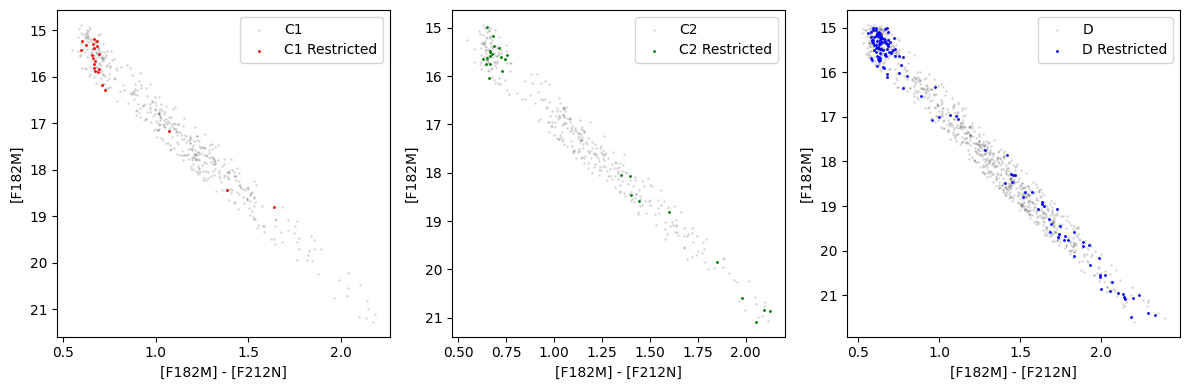

In [34]:
fig = plt.figure(figsize=(12,4))

plt.subplot(131)
cat_inbox_c1.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.1, color='k', label='C1')
cat_inbox_restricted_c1.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=1, color='r', label='C1 Restricted')
plt.gca().invert_yaxis()
plt.legend()

plt.subplot(132)
cat_inbox_c2.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.1, color='k', label='C2')
cat_inbox_restricted_c2.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=1, color='g', label='C2 Restricted')
plt.gca().invert_yaxis()
plt.legend()

plt.subplot(133)
cat_inbox_d.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=0.1, color='k', label='D')
cat_inbox_restricted_d.plot_CMD('f182m', 'f212n', 'f182m', s=1, alpha=1, color='b', label='D Restricted')
plt.gca().invert_yaxis()
plt.legend()

plt.tight_layout()

## Region Histograms

In [35]:
cat_inbox_lowE.catalog['Av'] = cat_inbox_lowE.get_Av('f182m', 'f212n')

cat_inbox_f = JWSTCatalog(cat_inbox_lowE.table_region_mask(reg_f, ww))
cat_inbox_c1 = JWSTCatalog(cat_inbox_lowE.table_region_mask(reg_c1_ice, ww))
cat_inbox_c2 = JWSTCatalog(cat_inbox_lowE.table_region_mask(reg_c2_ice, ww))
cat_inbox_d = JWSTCatalog(cat_inbox_lowE.table_region_mask(reg_d_ice, ww))
cat_inbox_b = JWSTCatalog(cat_inbox_lowE.table_region_mask(reg_b, ww))
cat_inbox_brick_reg = JWSTCatalog(cat_inbox_brick.table_region_mask(reg_brick, ww_brick))

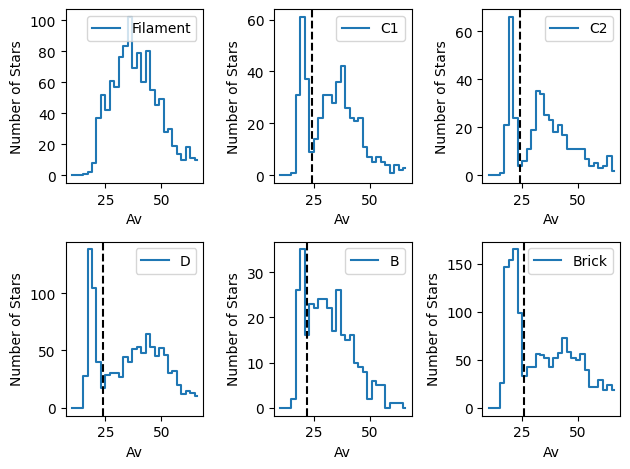

In [36]:
ax = plt.subplot(231)
hist_f = np.histogram(cat_inbox_f.catalog['Av'], bins=np.arange(10, 70, 2))
ax.step(hist_f[1][:-1], hist_f[0], where='mid', label='Filament')
plt.legend()
ax.set_xlabel('Av')
ax.set_ylabel('Number of Stars')

ax = plt.subplot(232)
hist_c1 = np.histogram(cat_inbox_c1.catalog['Av'], bins=np.arange(10, 70, 2))
ax.step(hist_c1[1][:-1], hist_c1[0], where='mid', label='C1')
plt.legend()
ax.set_xlabel('Av')
ax.set_ylabel('Number of Stars')
ax.axvline(24, color='k', linestyle='dashed')

ax = plt.subplot(233)
hist_c2 = np.histogram(cat_inbox_c2.catalog['Av'], bins=np.arange(10, 70, 2))
ax.step(hist_c2[1][:-1], hist_c2[0], where='mid', label='C2')
plt.legend()
ax.set_xlabel('Av')
ax.set_ylabel('Number of Stars')
ax.axvline(24, color='k', linestyle='dashed')

ax = plt.subplot(234)
hist_d = np.histogram(cat_inbox_d.catalog['Av'], bins=np.arange(10, 70, 2))
ax.step(hist_d[1][:-1], hist_d[0], where='mid', label='D')
plt.legend()
ax.set_xlabel('Av')
ax.set_ylabel('Number of Stars')
ax.axvline(24, color='k', linestyle='dashed')

ax = plt.subplot(235)
hist_b = np.histogram(cat_inbox_b.catalog['Av'], bins=np.arange(10, 70, 2))
ax.step(hist_b[1][:-1], hist_b[0], where='mid', label='B')
plt.legend()
ax.set_xlabel('Av')
ax.set_ylabel('Number of Stars')
ax.axvline(22, color='k', linestyle='dashed')

ax = plt.subplot(236)
hist_brick = np.histogram(cat_inbox_brick_reg.catalog['Av'], bins=np.arange(10, 70, 2))
ax.step(hist_brick[1][:-1], hist_brick[0], where='mid', label='Brick')
plt.legend()
ax.set_xlabel('Av')
ax.set_ylabel('Number of Stars')
ax.axvline(26, color='k', linestyle='dashed')

plt.tight_layout()
plt.show()

In [37]:
# effective_depth = fore / (fore + back)
fore_c1 = cat_inbox_c1.catalog['Av'] < 24
fore_c2 = cat_inbox_c2.catalog['Av'] < 24
fore_d = cat_inbox_d.catalog['Av'] < 24
fore_b = cat_inbox_b.catalog['Av'] < 22
fore_brick = cat_inbox_brick_reg.catalog['Av'] < 26

back_c1 = cat_inbox_c1.catalog['Av'] >= 24
back_c2 = cat_inbox_c2.catalog['Av'] >= 24
back_d = cat_inbox_d.catalog['Av'] >= 24
back_b = cat_inbox_b.catalog['Av'] >= 22
back_brick = cat_inbox_brick_reg.catalog['Av'] >= 26

print('C1 effective depth:', np.sum(fore_c1) / (np.sum(fore_c1) + np.sum(back_c1)))
print('C2 effective depth:', np.sum(fore_c2) / (np.sum(fore_c2) + np.sum(back_c2)))
print('D effective depth:', np.sum(fore_d) / (np.sum(fore_d) + np.sum(back_d)))
print('B effective depth:', np.sum(fore_b) / (np.sum(fore_b) + np.sum(back_b)))
print('Brick effective depth:', np.sum(fore_brick) / (np.sum(fore_brick) + np.sum(back_brick)))

C1 effective depth: 0.26804123711340205
C2 effective depth: 0.27860696517412936
D effective depth: 0.2857142857142857
B effective depth: 0.1891891891891892
Brick effective depth: 0.38376623376623376


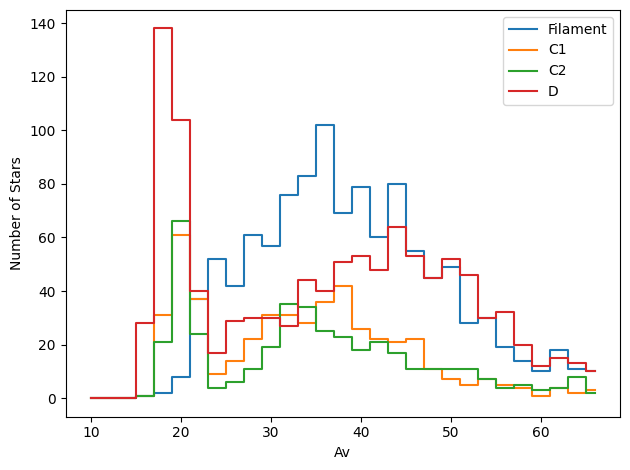

In [38]:
ax = plt.subplot(111)
hist_f = np.histogram(cat_inbox_f.catalog['Av'], bins=np.arange(10, 70, 2))
ax.step(hist_f[1][:-1], hist_f[0], where='mid', label='Filament')

hist_c1 = np.histogram(cat_inbox_c1.catalog['Av'], bins=np.arange(10, 70, 2))
ax.step(hist_c1[1][:-1], hist_c1[0], where='mid', label='C1')

hist_c2 = np.histogram(cat_inbox_c2.catalog['Av'], bins=np.arange(10, 70, 2))
ax.step(hist_c2[1][:-1], hist_c2[0], where='mid', label='C2')

hist_d = np.histogram(cat_inbox_d.catalog['Av'], bins=np.arange(10, 70, 2))
ax.step(hist_d[1][:-1], hist_d[0], where='mid', label='D')

plt.legend()
ax.set_xlabel('Av')
ax.set_ylabel('Number of Stars')

plt.tight_layout()
plt.show()

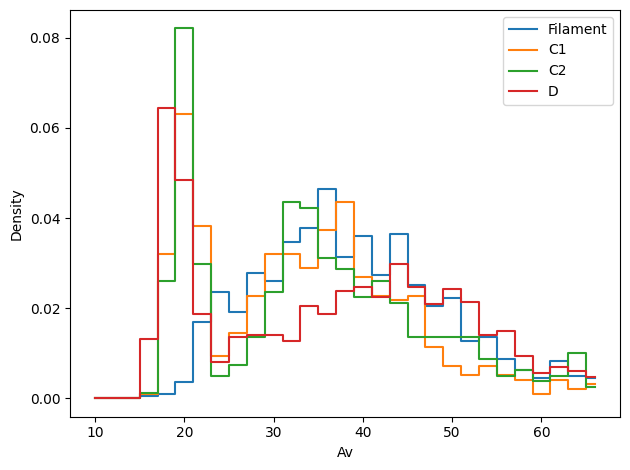

In [39]:
ax = plt.subplot(111)
hist_f = np.histogram(cat_inbox_f.catalog['Av'], bins=np.arange(10, 70, 2), density=True)
ax.step(hist_f[1][:-1], hist_f[0], where='mid', label='Filament')

hist_c1 = np.histogram(cat_inbox_c1.catalog['Av'], bins=np.arange(10, 70, 2), density=True)
ax.step(hist_c1[1][:-1], hist_c1[0], where='mid', label='C1')

hist_c2 = np.histogram(cat_inbox_c2.catalog['Av'], bins=np.arange(10, 70, 2), density=True)
ax.step(hist_c2[1][:-1], hist_c2[0], where='mid', label='C2')

hist_d = np.histogram(cat_inbox_d.catalog['Av'], bins=np.arange(10, 70, 2), density=True)
ax.step(hist_d[1][:-1], hist_d[0], where='mid', label='D')

plt.legend()
ax.set_xlabel('Av')
ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

# Focus on Ice

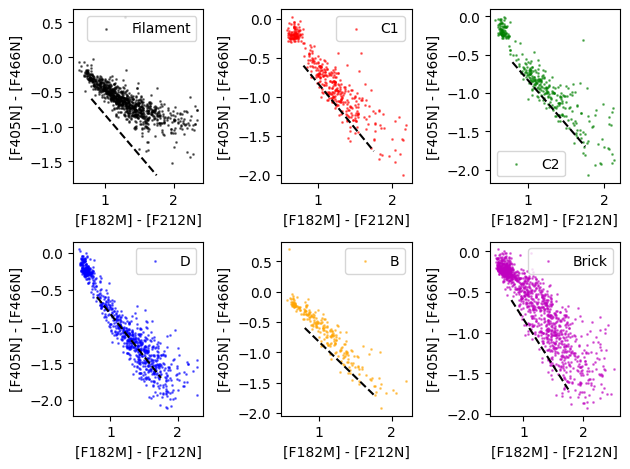

In [40]:
plt.subplot(231)
cat_inbox_f.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='k', label='Filament')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
plt.legend()

plt.subplot(232)
cat_inbox_c1.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='r', label='C1')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
plt.legend()

plt.subplot(233)
cat_inbox_c2.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='g', label='C2')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
plt.legend()

plt.subplot(234)
cat_inbox_d.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='b', label='D')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
plt.legend()

plt.subplot(235)
cat_inbox_b.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='orange', label='B')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
plt.legend()

plt.subplot(236)
cat_inbox_brick_reg.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='m', label='Brick')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
plt.legend()

plt.tight_layout()
#plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/ccds_by_region.png', dpi=300)

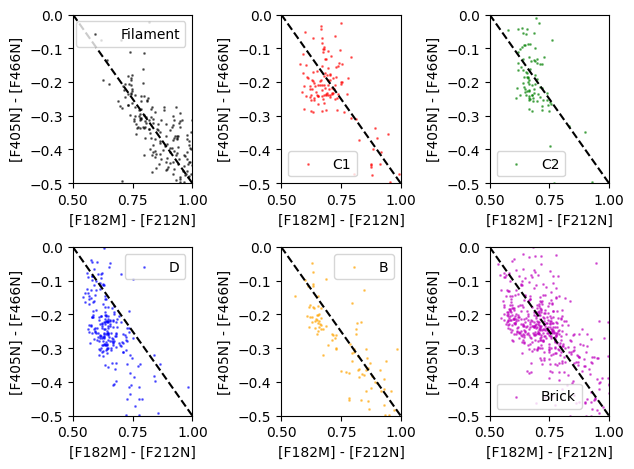

In [51]:
plt.subplot(231)
cat_inbox_f.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='k', label='Filament')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
plt.xlim(0.5, 1)
plt.ylim(-0.5, 0)
plt.legend()

plt.subplot(232)
cat_inbox_c1.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='r', label='C1')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
plt.xlim(0.5, 1)
plt.ylim(-0.5, 0)
plt.legend()

plt.subplot(233)
cat_inbox_c2.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='g', label='C2')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
plt.xlim(0.5, 1)
plt.ylim(-0.5, 0)
plt.legend()

plt.subplot(234)
cat_inbox_d.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='b', label='D')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
plt.xlim(0.5, 1)
plt.ylim(-0.5, 0)
plt.legend()

plt.subplot(235)
cat_inbox_b.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='orange', label='B')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
plt.xlim(0.5, 1)
plt.ylim(-0.5, 0)
plt.legend()

plt.subplot(236)
cat_inbox_brick_reg.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='m', label='Brick')
plt.plot([0.5, 1.], [-0, -0.5], color='k', linestyle='dashed')
plt.xlim(0.5, 1)
plt.ylim(-0.5, 0)
plt.legend()

plt.tight_layout()
#plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/ccds_by_region.png', dpi=300)

/scratch/local/22718070/ipykernel_1424469/805650685.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_inset.set_xticklabels(ax_inset.get_xticklabels(), fontsize=12)
/scratch/local/22718070/ipykernel_1424469/805650685.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_inset.set_yticklabels(ax_inset.get_yticklabels(), fontsize=12)
/scratch/local/22718070/ipykernel_1424469/805650685.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
/scratch/local/22718070/ipykernel_1424469/805650685.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
/scra

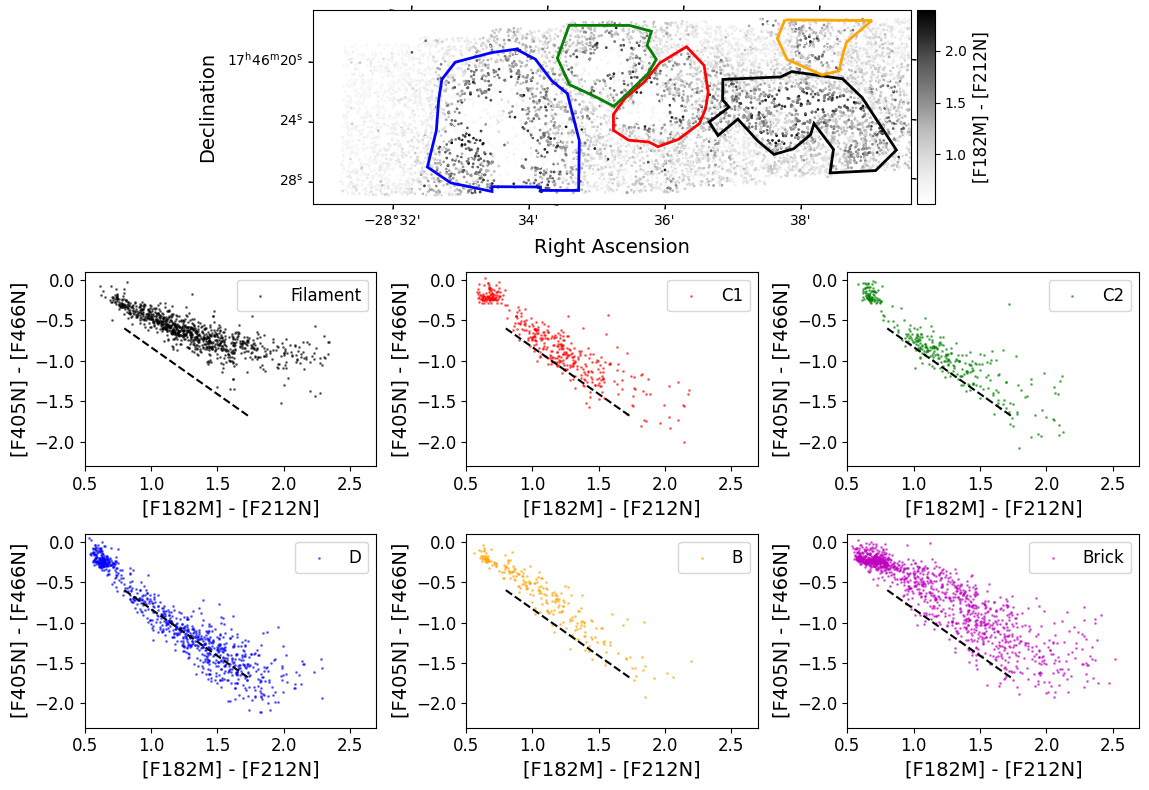

In [41]:
fig = plt.figure(figsize=(12,8))

ax_inset = plt.subplot(311, projection=ww)
ax_inset.imshow(nanfield)
cat_inbox_lowE.plot_position(s=1, c=cat_inbox_lowE.color('f182m', 'f212n'), cmap='Greys', transform=ax_inset.get_transform('world'), ax=ax_inset)
cax = ax_inset.inset_axes([1.01, 0., 0.03, 1])
ax_inset.set_xlabel('Right Ascension', fontsize=14)
ax_inset.set_ylabel('Declination', fontsize=14)
ax_inset.set_xticklabels(ax_inset.get_xticklabels(), fontsize=12)
ax_inset.set_yticklabels(ax_inset.get_yticklabels(), fontsize=12)
cb = plt.colorbar(ax_inset.collections[0], cax=cax, orientation='vertical')
cb.set_label('[F182M] - [F212N]', fontsize=12)

reg_f[0].to_pixel(ww).plot(ax=ax_inset, edgecolor='k', facecolor='none', lw=2)
reg_c1_ice[0].to_pixel(ww).plot(ax=ax_inset, edgecolor='r', facecolor='none', lw=2)
reg_c2_ice[0].to_pixel(ww).plot(ax=ax_inset, edgecolor='g', facecolor='none', lw=2)
reg_d_ice[0].to_pixel(ww).plot(ax=ax_inset, edgecolor='b', facecolor='none', lw=2)
reg_b[0].to_pixel(ww).plot(ax=ax_inset, edgecolor='orange', facecolor='none', lw=2)

ax = plt.subplot(334)
cat_inbox_f.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='k', label='Filament')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax.set_xlim(0.5, 2.7)
ax.set_ylim(-2.3, 0.1)
ax.set_xlabel('[F182M] - [F212N]', fontsize=14)
ax.set_ylabel('[F405N] - [F466N]', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.legend(fontsize=12)

ax = plt.subplot(335)
cat_inbox_c1.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='r', label='C1')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax.set_xlim(0.5, 2.7)
ax.set_ylim(-2.3, 0.1)
ax.set_xlabel('[F182M] - [F212N]', fontsize=14)
ax.set_ylabel('[F405N] - [F466N]', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.legend(fontsize=12)

ax = plt.subplot(336)
cat_inbox_c2.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='g', label='C2')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax.set_xlim(0.5, 2.7)
ax.set_ylim(-2.3, 0.1)
ax.set_xlabel('[F182M] - [F212N]', fontsize=14)
ax.set_ylabel('[F405N] - [F466N]', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.legend(fontsize=12)

ax = plt.subplot(337)
cat_inbox_d.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='b', label='D')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax.set_xlim(0.5, 2.7)
ax.set_ylim(-2.3, 0.1)
ax.set_xlabel('[F182M] - [F212N]', fontsize=14)
ax.set_ylabel('[F405N] - [F466N]', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.legend(fontsize=12)

ax = plt.subplot(338)
cat_inbox_b.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='orange', label='B')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax.set_xlim(0.5, 2.7)
ax.set_ylim(-2.3, 0.1)
ax.set_xlabel('[F182M] - [F212N]', fontsize=14)
ax.set_ylabel('[F405N] - [F466N]', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.legend(fontsize=12)

ax = plt.subplot(339)
cat_inbox_brick_reg.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='m', label='Brick')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
ax.set_xlim(0.5, 2.7)
ax.set_ylim(-2.3, 0.1)
ax.set_xlabel('[F182M] - [F212N]', fontsize=14)
ax.set_ylabel('[F405N] - [F466N]', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()

#ax_inset = ax.inset_axes([0.35, 1.2, 3.5, 1], projection=ww)
#ax = plt.subplot(projection=ww)


plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/ccds_by_region.png', dpi=300)

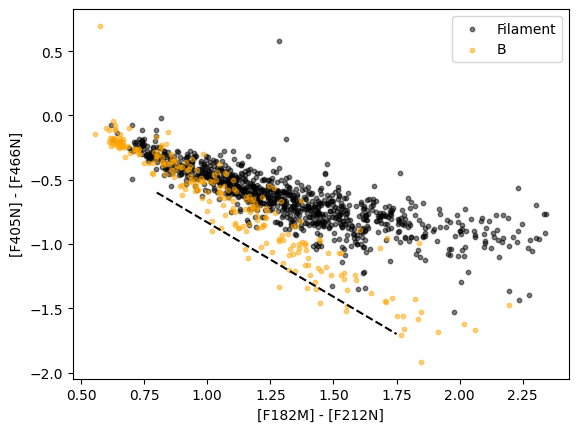

In [42]:
plt.subplot(111)
cat_inbox_f.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=10, alpha=0.5, color='k', label='Filament')
cat_inbox_b.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=10, alpha=0.5, color='orange', label='B')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
plt.legend()

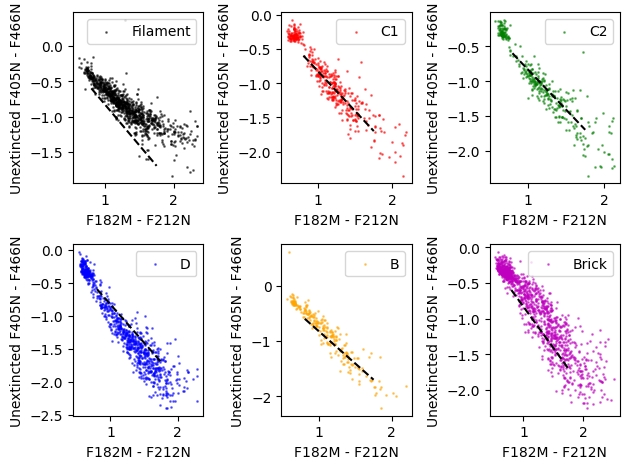

In [43]:
plt.subplot(231)
#cat_inbox_f.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='k', label='Filament')
plt.scatter(cat_inbox_f.color('f182m', 'f212n'), cat_inbox_f.catalog['unextinct_405_466'], s=1, alpha=0.5, color='k', label='Filament')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
plt.xlabel('F182M - F212N')
plt.ylabel('Unextincted F405N - F466N')
plt.legend()

plt.subplot(232)
#cat_inbox_c1.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='r', label='C1')
plt.scatter(cat_inbox_c1.color('f182m', 'f212n'), cat_inbox_c1.catalog['unextinct_405_466'], s=1, alpha=0.5, color='r', label='C1')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
plt.xlabel('F182M - F212N')
plt.ylabel('Unextincted F405N - F466N')
plt.legend()

plt.subplot(233)
#cat_inbox_c2.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='g', label='C2')
plt.scatter(cat_inbox_c2.color('f182m', 'f212n'), cat_inbox_c2.catalog['unextinct_405_466'], s=1, alpha=0.5, color='g', label='C2')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
plt.xlabel('F182M - F212N')
plt.ylabel('Unextincted F405N - F466N')
plt.legend()

plt.subplot(234)
#cat_inbox_d.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='b', label='D')
plt.scatter(cat_inbox_d.color('f182m', 'f212n'), cat_inbox_d.catalog['unextinct_405_466'], s=1, alpha=0.5, color='b', label='D')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
plt.xlabel('F182M - F212N')
plt.ylabel('Unextincted F405N - F466N')
plt.legend()

plt.subplot(235)
#cat_inbox_b.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='orange', label='B')
plt.scatter(cat_inbox_b.color('f182m', 'f212n'), cat_inbox_b.catalog['unextinct_405_466'], s=1, alpha=0.5, color='orange', label='B')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
plt.xlabel('F182M - F212N')
plt.ylabel('Unextincted F405N - F466N')
plt.legend()

plt.subplot(236)
#cat_inbox_brick_reg.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='m', label='Brick')
plt.scatter(cat_inbox_brick_reg.color('f182m', 'f212n'), cat_inbox_brick_reg.catalog['unextinct_405_466'], s=1, alpha=0.5, color='m', label='Brick')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
plt.xlabel('F182M - F212N')
plt.ylabel('Unextincted F405N - F466N')
plt.legend()

plt.tight_layout()

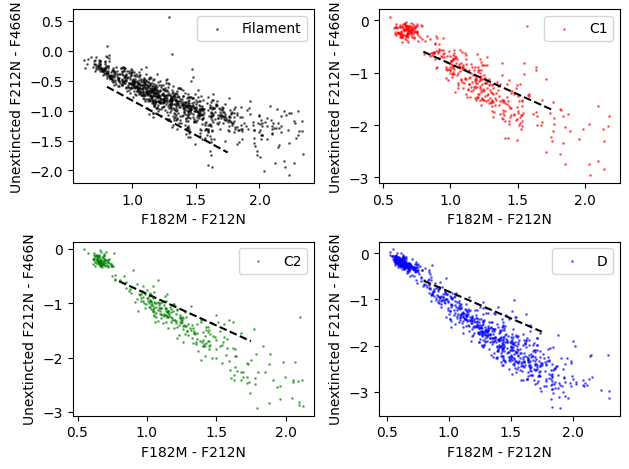

In [44]:
plt.subplot(221)
#cat_inbox_f.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='k', label='Filament')
plt.scatter(cat_inbox_f.color('f182m', 'f212n'), cat_inbox_f.catalog['unextinct_212_466'], s=1, alpha=0.5, color='k', label='Filament')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
plt.xlabel('F182M - F212N')
plt.ylabel('Unextincted F212N - F466N')
plt.legend()

plt.subplot(222)
#cat_inbox_c1.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='r', label='C1')
plt.scatter(cat_inbox_c1.color('f182m', 'f212n'), cat_inbox_c1.catalog['unextinct_212_466'], s=1, alpha=0.5, color='r', label='C1')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
plt.xlabel('F182M - F212N')
plt.ylabel('Unextincted F212N - F466N')
plt.legend()

plt.subplot(223)
#cat_inbox_c2.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='g', label='C2')
plt.scatter(cat_inbox_c2.color('f182m', 'f212n'), cat_inbox_c2.catalog['unextinct_212_466'], s=1, alpha=0.5, color='g', label='C2')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
plt.xlabel('F182M - F212N')
plt.ylabel('Unextincted F212N - F466N')
plt.legend()

plt.subplot(224)
#cat_inbox_d.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='b', label='D')
plt.scatter(cat_inbox_d.color('f182m', 'f212n'), cat_inbox_d.catalog['unextinct_212_466'], s=1, alpha=0.5, color='b', label='D')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')
plt.xlabel('F182M - F212N')
plt.ylabel('Unextincted F212N - F466N')
plt.legend()

plt.tight_layout()

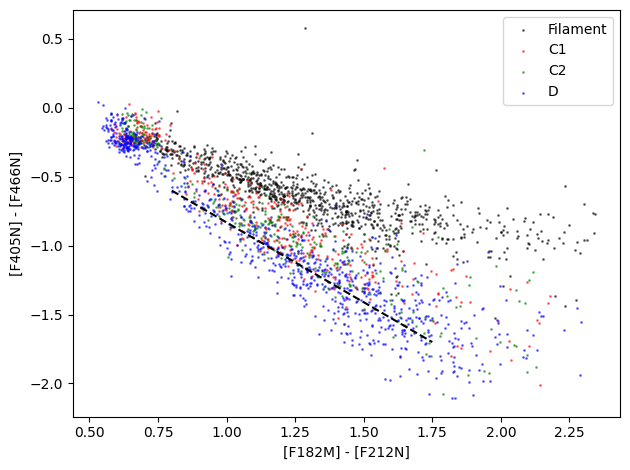

In [45]:
plt.subplot(111)
cat_inbox_f.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='k', label='Filament')
cat_inbox_c1.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='r', label='C1')
cat_inbox_c2.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='g', label='C2')
cat_inbox_d.plot_CCD('f182m', 'f212n', 'f405n', 'f466n', s=1, alpha=0.5, color='b', label='D')
plt.plot([0.8, 1.75], [-0.6, -1.7], color='k', linestyle='dashed')

plt.legend()
plt.tight_layout()

## Ice vs Av

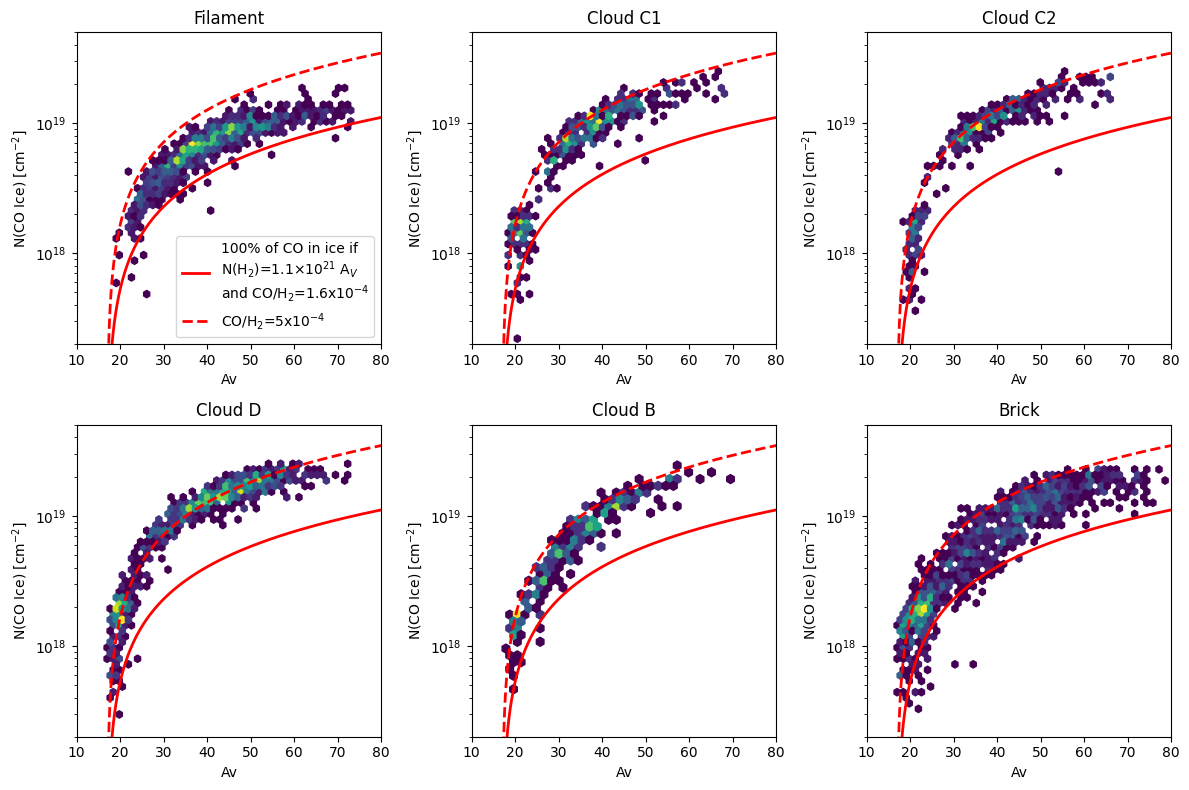

In [46]:
fig = plt.figure(figsize=(12,8))

ax = plt.subplot(231)
ax.hexbin(cat_inbox_f.catalog['Av'], cat_inbox_f.catalog['N(CO)'], yscale='log', extent=(10, 80, np.log10(2e17), np.log10(5e19)), cmap='viridis', gridsize=50, mincnt=1)
plt.xlabel('Av')
plt.ylabel('N(CO Ice) [cm$^{-2}$]')
plt.title('Filament')
Av_offset = 17
NCOofAV_alt1 = 1.1e21 * np.linspace(0.1, 100, 1000) * 5e-4
NCOofAV_alt3 = 1.1e21 * np.linspace(0.1, 100, 1000) * 1.6e-4
l1, = plt.plot(np.linspace(0.1, 100, 1000)+Av_offset, NCOofAV_alt3, linewidth=2, 
        label='100% of CO in ice if \nN(H$_2$)=1.1$\\times10^{21}$ A$_V$ \nand CO/H$_2$=1.6x10$^{-4}$', color='r', linestyle='-')
l3, = plt.plot(np.linspace(0.1, 100, 1000)+Av_offset, NCOofAV_alt1, linewidth=2, 
        label='CO/H$_2$=5x10$^{-4}$', color='r', linestyle='--')
plt.xlim(10, 80)
plt.ylim(2e17, 5e19)
plt.legend()

ax = plt.subplot(232)
ax.hexbin(cat_inbox_c1.catalog['Av'], cat_inbox_c1.catalog['N(CO)'], yscale='log', extent=(10, 80, np.log10(2e17), np.log10(5e19)), cmap='viridis', gridsize=50, mincnt=1)
plt.xlabel('Av')
plt.ylabel('N(CO Ice) [cm$^{-2}$]')
plt.title('Cloud C1')
l1, = plt.plot(np.linspace(0.1, 100, 1000)+Av_offset, NCOofAV_alt3, linewidth=2, 
        label='100% of CO in ice if \nN(H$_2$)=1.1$\\times10^{21}$ A$_V$ \nand CO/H$_2$=1.6x10$^{-4}$', color='r', linestyle='-')
l3, = plt.plot(np.linspace(0.1, 100, 1000)+Av_offset, NCOofAV_alt1, linewidth=2, 
        label='CO/H$_2$=5x10$^{-4}$', color='r', linestyle='--')
plt.xlim(10, 80)
plt.ylim(2e17, 5e19)

ax = plt.subplot(233)
ax.hexbin(cat_inbox_c2.catalog['Av'], cat_inbox_c2.catalog['N(CO)'], yscale='log', extent=(10, 80, np.log10(2e17), np.log10(5e19)), cmap='viridis', gridsize=50, mincnt=1)
plt.xlabel('Av')
plt.ylabel('N(CO Ice) [cm$^{-2}$]')
plt.title('Cloud C2')
l1, = plt.plot(np.linspace(0.1, 100, 1000)+Av_offset, NCOofAV_alt3, linewidth=2, 
        label='100% of CO in ice if \nN(H$_2$)=1.1$\\times10^{21}$ A$_V$ \nand CO/H$_2$=1.6x10$^{-4}$', color='r', linestyle='-')
l3, = plt.plot(np.linspace(0.1, 100, 1000)+Av_offset, NCOofAV_alt1, linewidth=2, 
        label='CO/H$_2$=5x10$^{-4}$', color='r', linestyle='--')
plt.xlim(10, 80)
plt.ylim(2e17, 5e19)

ax = plt.subplot(234)
ax.hexbin(cat_inbox_d.catalog['Av'], cat_inbox_d.catalog['N(CO)'], yscale='log', extent=(10, 80, np.log10(2e17), np.log10(5e19)), cmap='viridis', gridsize=50, mincnt=1)
plt.xlabel('Av')
plt.ylabel('N(CO Ice) [cm$^{-2}$]')
plt.title('Cloud D')
l1, = plt.plot(np.linspace(0.1, 100, 1000)+Av_offset, NCOofAV_alt3, linewidth=2, 
        label='100% of CO in ice if \nN(H$_2$)=1.1$\\times10^{21}$ A$_V$ \nand CO/H$_2$=1.6x10$^{-4}$', color='r', linestyle='-')
l3, = plt.plot(np.linspace(0.1, 100, 1000)+Av_offset, NCOofAV_alt1, linewidth=2, 
        label='CO/H$_2$=5x10$^{-4}$', color='r', linestyle='--')
plt.xlim(10, 80)
plt.ylim(2e17, 5e19)

ax = plt.subplot(235)
ax.hexbin(cat_inbox_b.catalog['Av'], cat_inbox_b.catalog['N(CO)'], yscale='log', extent=(10, 80, np.log10(2e17), np.log10(5e19)), cmap='viridis', gridsize=40, mincnt=1)
plt.xlabel('Av')
plt.ylabel('N(CO Ice) [cm$^{-2}$]')
plt.title('Cloud B')
l1, = plt.plot(np.linspace(0.1, 100, 1000)+Av_offset, NCOofAV_alt3, linewidth=2, 
        label='100% of CO in ice if \nN(H$_2$)=1.1$\\times10^{21}$ A$_V$ \nand CO/H$_2$=1.6x10$^{-4}$', color='r', linestyle='-')
l3, = plt.plot(np.linspace(0.1, 100, 1000)+Av_offset, NCOofAV_alt1, linewidth=2, 
        label='CO/H$_2$=5x10$^{-4}$', color='r', linestyle='--')
plt.xlim(10, 80)
plt.ylim(2e17, 5e19)

ax = plt.subplot(236)
ax.hexbin(cat_inbox_brick_reg.catalog['Av'], cat_inbox_brick_reg.catalog['N(CO)'], yscale='log', extent=(10, 80, np.log10(2e17), np.log10(5e19)), cmap='viridis', gridsize=50, mincnt=1)
plt.xlabel('Av')
plt.ylabel('N(CO Ice) [cm$^{-2}$]')
plt.title('Brick')
l1, = plt.plot(np.linspace(0.1, 100, 1000)+Av_offset, NCOofAV_alt3, linewidth=2, 
        label='100% of CO in ice if \nN(H$_2$)=1.1$\\times10^{21}$ A$_V$ \nand CO/H$_2$=1.6x10$^{-4}$', color='r', linestyle='-')
l3, = plt.plot(np.linspace(0.1, 100, 1000)+Av_offset, NCOofAV_alt1, linewidth=2, 
        label='CO/H$_2$=5x10$^{-4}$', color='r', linestyle='--')
plt.xlim(10, 80)
plt.ylim(2e17, 5e19)

plt.tight_layout()
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/Av_vs_NCO_by_region.png', dpi=300, bbox_inches='tight')
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/Av_vs_NCO_by_region.pdf', bbox_inches='tight')
plt.show()